<a href="https://colab.research.google.com/github/Gasca78/Movie_Recommender_Project/blob/main/Movie_Recommender_System_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PROBLEMA DE NEGOCIO**


---




##Imagina tener acceso a los datos de una plataforma de streaming y usar esos datos para mejorar la experiencia del usuario. Como científicos de datos, analizarán estos datos con Python y construirán un recomendador de películas personalizado que ofrecerá sugerencias precisas y relevantes, revolucionando la forma en que los usuarios descubren nuevos contenidos.

### **Objetivos**

1. Recomendador no personalizado

2. Recomendador Content-based

3. Recomendador Collaborative filtering

#**1. Configuración del Ambiente**


---




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import zipfile
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import linear_kernel
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
!curl http://files.grouplens.org/datasets/movielens/ml-latest-small.zip -o ml-latest-small.zip
with zipfile.ZipFile('ml-latest-small.zip', 'r') as zip_ref:
    zip_ref.extractall('data')
global df_movies, df_ratings, df_final

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0   786k      0  0:00:01  0:00:01 --:--:--  786k


#**2. Obtención, Tratamiento y Análisis Exploratório (EDA)**


---




##**2.1 Cargando las bases de datos**

In [2]:
df_movies = pd.read_csv('data/ml-latest-small/movies.csv')
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
df_ratings = pd.read_csv('data/ml-latest-small/ratings.csv')
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.00,964982703
1,1,3,4.00,964981247
2,1,6,4.00,964982224
3,1,47,5.00,964983815
4,1,50,5.00,964982931


##**2.2 Tratamiento de Datos**

In [4]:
print(df_movies.info())
print('-------------')
print(df_ratings.info())
print('-------------')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None
-------------


In [5]:
#@title
def preprocesamiento():
  global df_movies, df_ratings
  # Eliminamos registros nullos en ambos DataFrames:
  df_movies = df_movies.dropna()
  df_ratings = df_ratings.dropna()
  # Eliminamos duplicados en ambos DataFrames:
  df_movies = df_movies.drop_duplicates(subset = 'movieId', keep = 'first') # Consideramos a la columna movieId como llave
  df_ratings = df_ratings.drop_duplicates(subset = ['movieId','userId'], keep = 'first') # Consideramos a las columnas movieId y userId como llave
  # Creación de columna content en ambos DataFrames para hacer el string de los géneros:
  df_movies['content'] = df_movies['genres'].str.replace('|', ' ') # Separamos los generos por un espacio
  # Creación de columna genres_set en ambos DataFrames para hacer el conjunto de géneros:
  df_movies['genres_set'] = df_movies['genres'].str.split('|') # Separamos los generos
  df_movies['genres_set'] = df_movies['genres_set'].apply(lambda x: set(x))
  # Cambio del tipo de dato en el campo timestamp en df_ratings:
  df_ratings['timestamp'] = pd.to_datetime(df_ratings['timestamp'], unit='s') # Convertimos a formato de fecha

In [6]:
preprocesamiento()
print(df_movies.info())
print('-------------')
print(df_ratings.info())
print('-------------')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   movieId     9742 non-null   int64 
 1   title       9742 non-null   object
 2   genres      9742 non-null   object
 3   content     9742 non-null   object
 4   genres_set  9742 non-null   object
dtypes: int64(1), object(4)
memory usage: 380.7+ KB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     100836 non-null  int64         
 1   movieId    100836 non-null  int64         
 2   rating     100836 non-null  float64       
 3   timestamp  100836 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 3.1 MB
None
-------------


In [7]:
df_movies.head()

,movieId,title,genres,content,genres_set
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Fantasy, Animation, Comedy, Children, Adventure}"
1,2,Jumanji (1995),Adventure|Children|Fantasy,Adventure Children Fantasy,"{Fantasy, Children, Adventure}"
2,3,Grumpier Old Men (1995),Comedy|Romance,Comedy Romance,"{Comedy, Romance}"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Comedy Drama Romance,"{Comedy, Romance, Drama}"
4,5,Father of the Bride Part II (1995),Comedy,Comedy,{Comedy}


In [8]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.00,2000-07-30 18:45:03
1,1,3,4.00,2000-07-30 18:20:47
2,1,6,4.00,2000-07-30 18:37:04
3,1,47,5.00,2000-07-30 19:03:35
4,1,50,5.00,2000-07-30 18:48:51


##**2.3 Análisis Exploratorio (EDA)**

In [9]:
df_movies.describe()

,movieId
count,9742.00
mean,42200.35
std,52160.49
min,1.00
25%,3248.25
50%,7300.00
75%,76232.00
max,193609.00


In [10]:
df_ratings.describe()

,userId,movieId,rating,timestamp
count,100836.00,100836.00,100836.00,100836
mean,326.13,19435.30,3.50,2008-03-19 17:01:27.368469248
min,1.00,1.00,0.50,1996-03-29 18:36:55
25%,177.00,1199.00,3.00,2002-04-18 09:57:46
50%,325.00,2991.00,3.50,2007-08-02 20:31:02
75%,477.00,8122.00,4.00,2015-07-04 07:15:44.500000
max,610.00,193609.00,5.00,2018-09-24 14:27:30
std,182.62,35530.99,1.04,NaN


In [11]:
# Creamos un dataframe "final" donde unimos ambos dataframe procesados anteriormente
df_final = pd.merge(df_ratings, df_movies, on='movieId')

In [12]:
df_final.describe()

,userId,movieId,rating,timestamp
count,100836.00,100836.00,100836.00,100836
mean,326.13,19435.30,3.50,2008-03-19 17:01:27.368469504
min,1.00,1.00,0.50,1996-03-29 18:36:55
25%,177.00,1199.00,3.00,2002-04-18 09:57:46
50%,325.00,2991.00,3.50,2007-08-02 20:31:02
75%,477.00,8122.00,4.00,2015-07-04 07:15:44.500000
max,610.00,193609.00,5.00,2018-09-24 14:27:30
std,182.62,35530.99,1.04,NaN


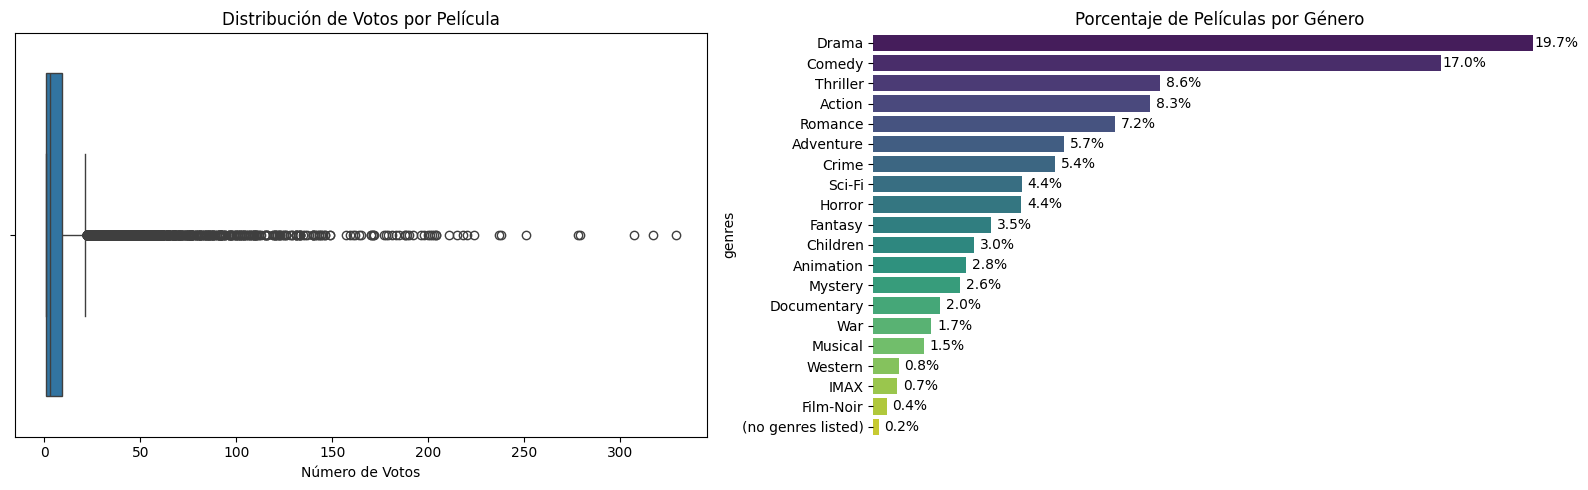

In [13]:
#@title
# Crear una figura con subplots
fig, (g1, g2) = plt.subplots(1, 2, figsize=(16, 5))

# Primero obtenemos un Series donde dividimos y obtenemos cada género
df_movies_genres = df_movies['genres'].str.split('|') # Separamos los generos
df_movies_genres = df_movies_genres.explode() # Separamos cada genero
df_movies_genres = df_movies_genres.value_counts() # Agrupamos y tenemos la cuenta de cuántas veces aparece cada género
total_count = df_movies_genres.sum() # Obtenemos la suma total de generos que usaremos para sacar los porcentajes
for genre in df_movies_genres.index:
  df_movies_genres_percentage = (df_movies_genres / total_count) * 100 # Sacamos los porcentajes para cada género
index = df_movies_genres_percentage.index
values = df_movies_genres_percentage.values

# Proceso para la grafica de boxplot
# Creamos una variable que tome a las películas y sus votos totales
df_movies_votes = df_final.groupby('title').size().reset_index(name='votes')
df_movies_votes = df_movies_votes.sort_values('votes', ascending=False) # Ordenamos de mayor a menor

# Generamos la gráfica de boxplot utilizando las variables anteriormente creadas df_final y df_movies_votes
sns.boxplot(x = df_movies_votes['votes'], ax = g1)
g1.set_xlabel('Número de Votos')
g1.set_title('Distribución de Votos por Película')

# Generamos la gráfica de barras con los generos
sns.barplot(x = values, y = index, ax = g2, palette = "viridis", hue = index) # palette indica la paleta de colores de la gráfica, mientras que hue es para indicar que usara cómo divisor para los colores
g2.set_xticks([]) # Eliminamos los valores del eje x
sns.despine(ax=g2, left=True, bottom=True) # Eliminamos el marco
g2.set_title('Porcentaje de Películas por Género')
# Añadir los porcentajes en las barras
for i in g2.patches:
    g2.text(i.get_width() + 0.7, i.get_y() + i.get_height() / 2,
            f'{i.get_width():.1f}%',
            ha='center', va='center')
# Mostrar la figura
plt.tight_layout()
plt.show()

        votes
count 8669.00
mean     4.42
std      5.08
min      1.00
25%      1.00
50%      2.00
75%      6.00
max     24.00
        votes
count 1012.00
mean    60.84
std     41.75
min     26.00
25%     34.00
50%     46.00
75%     70.00
max    329.00


Text(0.5, 1.0, 'Distribución de Votos por Película')

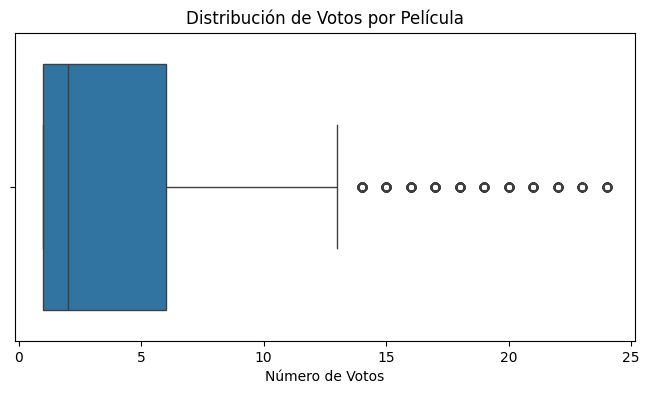

In [14]:
df_movies_votes = df_final.groupby('title').size().reset_index(name='votes')
df_movies_votes = df_movies_votes.sort_values('votes', ascending=False)
df_movies_votes_box = df_movies_votes[df_movies_votes['votes'] < 25]
df_movies_votes_upper = df_movies_votes[df_movies_votes['votes'] > 25]
print(df_movies_votes_box.describe())
print(df_movies_votes_upper.describe())
plt.figure(figsize=(8, 4))
sns.boxplot(x = df_movies_votes_box['votes'])
plt.xlabel('Número de Votos')
plt.title('Distribución de Votos por Película')

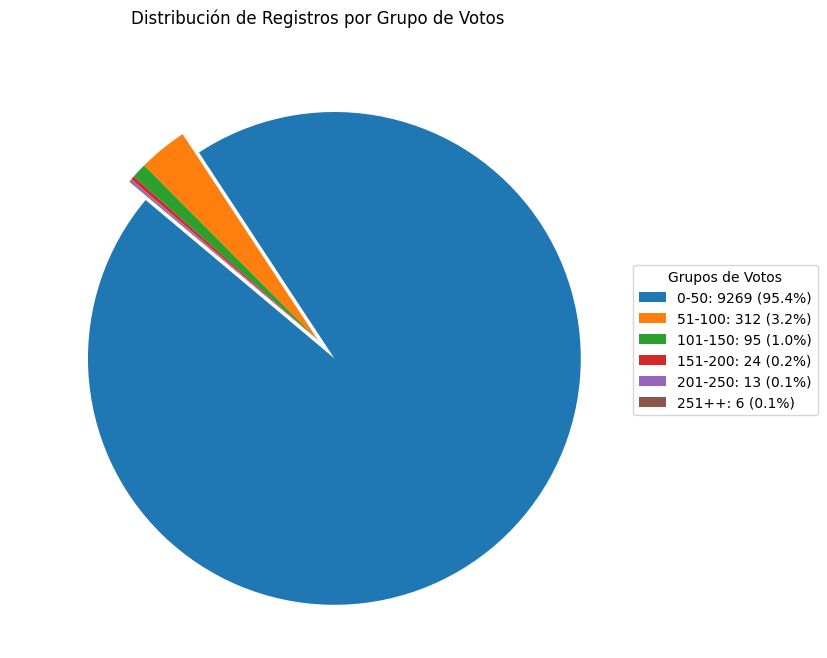

In [15]:
# Contamos los votos por película
votes_per_movie = df_final.groupby('title').size().reset_index(name='votes')

# Creamos las categorías de rangos de votos
bins = [0, 50, 100, 150, 200, 250, float('inf')]
labels = ['0-50', '51-100', '101-150', '151-200', '201-250', '251++']

# Asignamos cada película a un grupo basado en la cantidad de votos
votes_per_movie['vote_group'] = pd.cut(votes_per_movie['votes'], bins=bins, labels=labels, right=False)

# Contamos cuántos registros hay en cada grupo
group_counts = votes_per_movie['vote_group'].value_counts().sort_index()

# Calculamos los porcentajes para la leyenda
percentages = group_counts / group_counts.sum() * 100
legend_labels = [f'{label}: {count} ({pct:.1f}%)' for label, count, pct in zip(group_counts.index, group_counts, percentages)]

# Explosión de la porción más grande
explode = [0.1 if label == '0-50' else 0 for label in labels]

# Crear el gráfico de pastel sin etiquetas ni porcentajes en el gráfico
fig, ax = plt.subplots(figsize=(10, 8))
wedges, _ = ax.pie(group_counts, startangle=140, explode=explode)

# Añadir la leyenda con los porcentajes
ax.legend(wedges, legend_labels, title="Grupos de Votos", loc="center left", bbox_to_anchor=(1, 0.5))

ax.set_title('Distribución de Registros por Grupo de Votos')
plt.show()

In [16]:
# Contamos los votos por película
votes_per_movie = df_final.groupby('title').size().reset_index(name='votes')

# Valores mínimo y máximo de votos
min_votes = votes_per_movie['votes'].min()
max_votes = votes_per_movie['votes'].max()

# Contar cuántas películas tienen 0 votos (si es que hay)
zero_votes_count = votes_per_movie[votes_per_movie['votes'] == 0].shape[0]

print(f"Rango de votos: {min_votes} - {max_votes}")
print(f"Cantidad de películas con 0 votos: {zero_votes_count}")

Rango de votos: 1 - 329
Cantidad de películas con 0 votos: 0


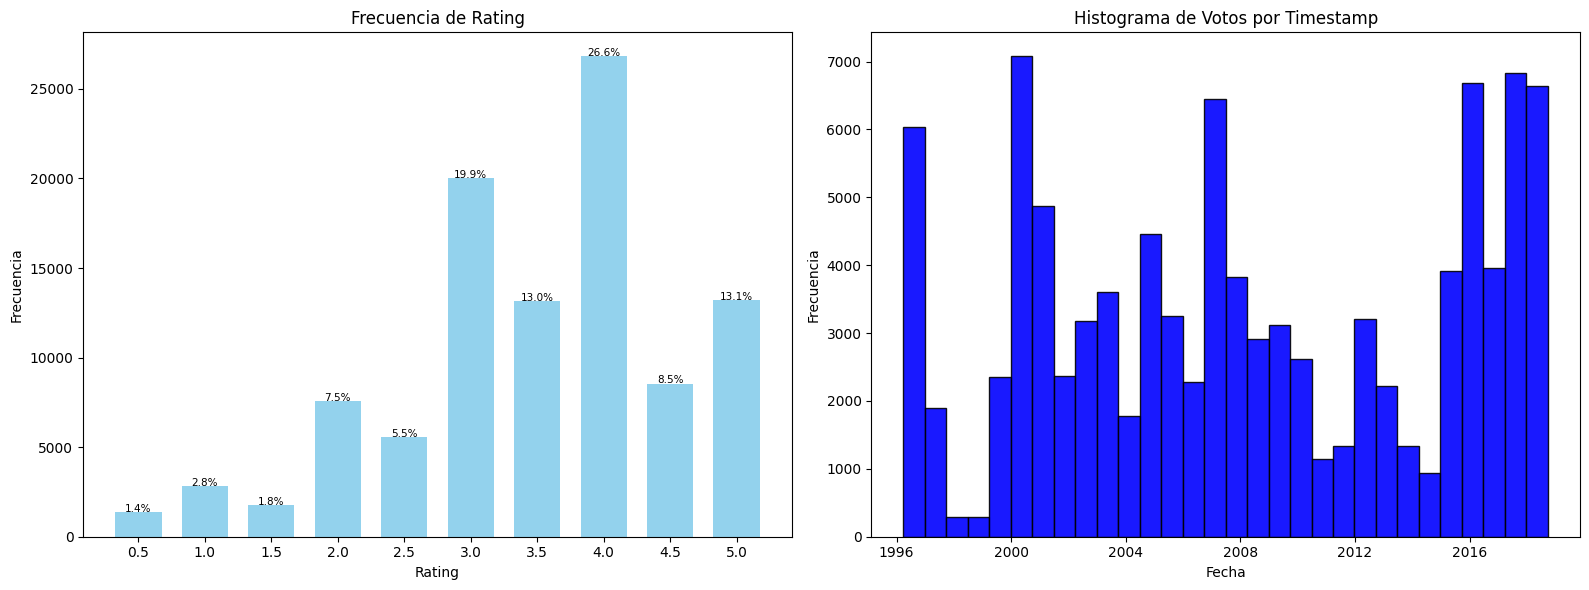

In [17]:
#@title
# Crear la figura con dos subgráficos
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de barras verticales para rating con barras más delgadas
# Calcular los valores y porcentajes de los ratings
rating_counts = df_final['rating'].value_counts().sort_index()
rating_percentages = (rating_counts / rating_counts.sum()) * 100

# Ajustar el ancho de las barras
bar_width = 0.4
spacing = 0.15
x = rating_counts.index
bar_positions = x + spacing * (x - x.min())

# Dibujar el gráfico de barras
bars = ax[0].bar(bar_positions, rating_counts, width=bar_width, color='skyblue', alpha=0.9)

# Añadir los porcentajes sobre cada barra
for bar, percentage in zip(bars, rating_percentages):
    height = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width() / 2, height + 5, f'{percentage:.1f}%', ha='center', fontsize=7.5)

ax[0].set_title('Frecuencia de Rating')
ax[0].set_xlabel('Rating')
ax[0].set_ylabel('Frecuencia')

ax[0].set_xticks(bar_positions)
ax[0].set_xticklabels(x)

# Histograma de timestamp con contorno para cada barra
n, bins, patches = ax[1].hist(df_final['timestamp'], bins=30, color='blue', alpha=0.9, edgecolor='black')
ax[1].set_title('Histograma de Votos por Timestamp')
ax[1].set_xlabel('Fecha')
ax[1].set_ylabel('Frecuencia')

plt.tight_layout()

plt.show()

#**3. Estrategias de Recomendación**


---




##**3.1 Recomendación no personalizada**

In [18]:
#@title
def recomendacion_populares():
  global df_final

  global_mean_rating = df_final['rating'].mean()
  total_votes = df_final['title'].value_counts().sum()
  vote_counts = df_final['title'].value_counts()
  movie_ratings = df_final.groupby('title')['rating'].mean()

  df_movie_stats = pd.DataFrame({
      'mean_rating': movie_ratings,
      'vote_count': vote_counts
  })

  # Calcular el promedio bayesiano
  C = df_movie_stats['mean_rating'].mean()  # Rating promedio global
  m = 25  # Umbral mínimo de votos

  df_movie_stats['weighted_rating'] = (
      (df_movie_stats['vote_count'] / (df_movie_stats['vote_count'] + m) * df_movie_stats['mean_rating'])
      + (m / (df_movie_stats['vote_count'] + m) * C)
  )

  top_10_movies = df_movie_stats.sort_values(by='weighted_rating', ascending=False).head(10)

  print("Top 10 Películas Más Populares (Ordenadas por Promedio Bayesiano):")

  return top_10_movies

In [19]:
recomendacion_populares()

Top 10 Películas Más Populares (Ordenadas por Promedio Bayesiano):


,mean_rating,vote_count,weighted_rating
title,,,
"Shawshank Redemption, The (1994)",4.43,317,4.34
"Godfather, The (1972)",4.29,192,4.17
Fight Club (1999),4.27,218,4.17
Star Wars: Episode IV - A New Hope (1977),4.23,251,4.14
"Usual Suspects, The (1995)",4.24,204,4.13
Schindler's List (1993),4.22,220,4.13
Pulp Fiction (1994),4.20,307,4.13
"Matrix, The (1999)",4.19,278,4.12
Star Wars: Episode V - The Empire Strikes Back (1980),4.22,211,4.11


##**3.2 Recomendación Content-Based**

###**3.2.1 Similitud de Jaccard**

In [20]:
# Creamos la función para calcular la similaridad de Jaccard
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

In [21]:
#@title
def recomendacion_jaccard(movie_id, df_movies, n_recommendations=10):
  input_genres = df_movies[df_movies['movieId']== movie_id]['genres_set'].values[0]

  # calculamos la similitud para cada fila
  df_movies['similarity']= df_movies['genres_set'].apply(lambda x: jaccard_similarity(input_genres,x))

  # Ordenamo las películas por similitud en orden descendente
  df_movies_sorted = df_movies.sort_values(by='similarity', ascending=False)

  # Filtrar para excluir la película de entrada
  df_movies_sorted = df_movies_sorted[df_movies_sorted['movieId'] != movie_id]

  # Seleccionar las n recomendaciones más similares
  recommendations = df_movies_sorted.head(n_recommendations)
  return recommendations[['movieId', 'title', 'genres','similarity']]

In [22]:
recomendaciones = recomendacion_jaccard(1, df_movies, n_recommendations=10)
recomendaciones

,movieId,title,genres,similarity
6194,45074,"Wild, The (2006)",Adventure|Animation|Children|Comedy|Fantasy,1.00
1706,2294,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy,1.00
9430,166461,Moana (2016),Adventure|Animation|Children|Comedy|Fantasy,1.00
8219,103755,Turbo (2013),Adventure|Animation|Children|Comedy|Fantasy,1.00
6948,65577,"Tale of Despereaux, The (2008)",Adventure|Animation|Children|Comedy|Fantasy,1.00
2809,3754,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,1.00
8927,136016,The Good Dinosaur (2015),Adventure|Animation|Children|Comedy|Fantasy,1.00
3568,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,1.00
3000,4016,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,1.00
7760,91355,Asterix and the Vikings (Astérix et les Viking...,Adventure|Animation|Children|Comedy|Fantasy,1.00


###**3.2.2 Similitud de Coseno con TF-IDF**

In [23]:
# Crear el vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
# Ajustar y transformar los datos de 'content' de df_movies
tfidf_matrix = tfidf_vectorizer.fit_transform(df_movies['content'])
# Calcular la matriz de similitud de coseno
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [24]:
#@title
def recomendacion_tf_idf(movie_id, df_movies, cosine_sim, n_recommendations):
  # Obtenemos el índice de la película seleccionada
  idx = df_movies[df_movies['movieId'] == movie_id].index[0]
  # Creamos una tupla con las puntuaciones de la película seleccionada
  score_cosine = list(enumerate(cosine_sim[idx]))
  # Ordenamos las películas según su puntuación de similitud
  score_cosine = sorted(score_cosine, key=lambda x: x[1], reverse=True)
  # Obtenemos los índices de las 10 películas más similares
  score_cosine = score_cosine[1:n_recommendations+1]
  movie_indices = [i[0] for i in score_cosine]
  # Obtenemos los títulos de las películas recomendadas
  df_recommendations = df_movies.iloc[movie_indices][['movieId','title','genres']]
  # Añadimos una columna donde mostramos la distancia entre las películas
  df_recommendations['distance'] = [i[1] for i in score_cosine]
  movie_title = df_movies[df_movies['movieId'] == movie_id]['title'].values[0] # Obtenemos el titulo de la pelicula
  print(f'Las {n_recommendations} películas más similares a {movie_title} son: ')
  return df_recommendations

In [25]:
recomendaciones = recomendacion_tf_idf(58559, df_movies, cosine_sim, n_recommendations=10)
recomendaciones

Las 10 películas más similares a Dark Knight, The (2008) son: 


,movieId,title,genres,distance
8387,109850,Need for Speed (2014),Action|Crime|Drama|IMAX,1.00
5917,33794,Batman Begins (2005),Action|Crime|IMAX,0.96
7599,86644,"Fast Five (Fast and the Furious 5, The) (2011)",Action|Crime|Drama|Thriller|IMAX,0.93
6852,62081,Eagle Eye (2008),Action|Crime|Thriller|IMAX,0.89
8103,100498,"Good Day to Die Hard, A (2013)",Action|Crime|Thriller|IMAX,0.89
8166,102716,"Fast & Furious 6 (Fast and the Furious 6, The)...",Action|Crime|Thriller|IMAX,0.89
8149,102088,"Grandmaster, The (Yi dai zong shi) (2013)",Action|Drama|IMAX,0.89
7768,91529,"Dark Knight Rises, The (2012)",Action|Adventure|Crime|IMAX,0.87
8233,104129,Man of Tai Chi (2013),Action|IMAX,0.85
8201,103339,White House Down (2013),Action|Drama|Thriller|IMAX,0.82


##**3.3 Recomendación Collaborative Filtering**

In [26]:
# Creamos una matriz con los usuarios como filas y las películas como columnas
rating_matrix = df_ratings.pivot_table(index='userId', columns='movieId', values='rating')
# Normalizamos la matriz y rellenamos los NaN con 0
avg_ratings = rating_matrix.mean(axis=1)
rating_matrix_normalized = rating_matrix.sub(avg_ratings, axis=0).fillna(0)
# Entrenamos el modelo KNN
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(rating_matrix_normalized.values)

NearestNeighbors(algorithm='brute', metric='cosine')

In [30]:
#@title
def recomendacion_knn(usuario_id_o_ratings, ratings_matrix_normalized, ratings_matrix, df_movies, knn_model, n_recommendations=10):
  # Identificamos si el usuario es nuevo o ya existe en el data frame
  if isinstance(usuario_id_o_ratings, pd.Series):
    usuario_id_o_ratings = pd.DataFrame(usuario_id_o_ratings).transpose() # Convetimos al usuario en un dataframe
    usuario_id_o_ratings_complete = usuario_id_o_ratings.reindex(columns=rating_matrix.columns) # Usamos reindex para crear las columnas de las películas para el usuario y asignar a su lugar correcta la calificación
    avg_user = usuario_id_o_ratings_complete.mean(axis=1) # Calculamos el promedio del usuario
    usuario_id_o_ratings_normalized = usuario_id_o_ratings_complete.sub(avg_user, axis=0).fillna(0) # Normalizamos las calificaciones del nuevo usuario
    # Obtenemos la distancia los índices de las películas después de pasar por el modelo KNN
    distances, indices = knn_model.kneighbors(usuario_id_o_ratings_normalized.values, n_neighbors=11)

  # Si isinstance() regresa "False" quiere decir que es un usuario nuevo y las entradas son calificaciones de películas
  else:
    # Obtenemos el indice de la película
    movie_index = rating_matrix.index.get_loc(usuario_id_o_ratings)
    # Obtenemos el Series del usuario y lo convertimos en un dataframe
    usuario_id_o_ratings = pd.DataFrame(rating_matrix_normalized.iloc[movie_index])
    # Obtenemos la distancia los índices de las películas después de pasar por el modelo KNN
    distances, indices = knn_model.kneighbors(usuario_id_o_ratings.values.reshape(1, -1), n_neighbors=11)

  # Dividimos las distancias y los indices en arreglos individuales unidimensionales
  distances = distances.flatten()[1:]
  indices = indices.flatten()[1:]
  # Obtenemos a los usuarios similares
  similar_users = rating_matrix_normalized.iloc[indices]
  # Calculamos la similitud de los usuarios, transponemos el dataframe users para poder obtener el promedio de cada uno
  mean_ratings = similar_users.T.dot(distances) / np.sum(distances)
  # Convertimos la información en un data frame
  mean_ratings = pd.DataFrame(mean_ratings, index = rating_matrix.columns, columns=['mean_rating'])
  # Eliminamos las películas que el usuario ya haya visto
  mean_ratings = mean_ratings.drop(usuario_id_o_ratings.columns, axis=0)
  # Eliminamos valores nulos
  mean_ratings = mean_ratings.dropna()
  # Tomamos los datos título y géneros de las peliculas y las combinamos con el rating promedio obtenido en un nuevo dataframe para su exposición
  df_movies_colab = pd.merge(df_movies[['movieId','title','genres']], mean_ratings, on='movieId')
  # Ordenamos los valores de manera descendiente
  df_movies_colab = df_movies_colab.sort_values(by='mean_rating', ascending=False)
  recommendations = df_movies_colab.head(10)
  print("Te mostramos otras 10 películas que podrían gustarte basado en los gustos de usuarios similares a ti: ")

  return recommendations

In [31]:
usuario = 15
# usuario = pd.Series({
#     356: 4,
#     58559: 5
# })

recomendaciones = recomendacion_knn(usuario, rating_matrix_normalized, rating_matrix, df_movies, knn_model)
recomendaciones

Te mostramos otras 10 películas que podrían gustarte basado en los gustos de usuarios similares a ti: 


,movieId,title,genres,mean_rating
276,318,"Shawshank Redemption, The (1994)",Crime|Drama,0.82
223,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,0.80
460,527,Schindler's List (1993),Drama|War,0.63
506,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi,0.63
896,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,0.61
313,356,Forrest Gump (1994),Comedy|Drama|Romance|War,0.59
1937,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.53
1501,2028,Saving Private Ryan (1998),Action|Drama|War,0.46
658,858,"Godfather, The (1972)",Crime|Drama,0.44
2669,3578,Gladiator (2000),Action|Adventure|Drama,0.41


In [32]:
# usuario = 15
usuario = pd.Series({
    356: 4,
    58559: 5
})

recomendaciones = recomendacion_knn(usuario, rating_matrix_normalized, rating_matrix, df_movies, knn_model)
recomendaciones

Te mostramos otras 10 películas que podrían gustarte basado en los gustos de usuarios similares a ti: 


,movieId,title,genres,mean_rating
1937,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.43
277,318,"Shawshank Redemption, The (1994)",Crime|Drama,0.19
123,150,Apollo 13 (1995),Adventure|Drama|IMAX,0.19
658,858,"Godfather, The (1972)",Crime|Drama,0.18
287,329,Star Trek: Generations (1994),Adventure|Drama|Sci-Fi,0.17
321,364,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX,0.17
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,0.16
6724,59315,Iron Man (2008),Action|Adventure|Sci-Fi,0.15
900,1200,Aliens (1986),Action|Adventure|Horror|Sci-Fi,0.14
6866,63082,Slumdog Millionaire (2008),Crime|Drama|Romance,0.13
